In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump,load

In [3]:
df = pd.read_json("./Video_Games_5.json", lines=True)

In [12]:
df["sentiment"] = df["overall"].apply(
    lambda rating: 0 if rating <= 2 else (1 if rating <= 4 else 2)
)

In [13]:
#df["reviewText"].fillna("", inplace=True)
df.fillna({"reviewText": ""}, inplace=True)
# 1. Rimozione dei caratteri speciali
df["reviewText"] = df["reviewText"].apply(lambda x: re.sub(r"\W", " ", str(x)))

stop_words = set(stopwords.words("english"))
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([word for word in word_tokenize(x) if word not in stop_words])
)

stemmer = PorterStemmer()
df["reviewText"] = df["reviewText"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in word_tokenize(x)])
)

In [15]:
vectorizer = TfidfVectorizer()
reviews_tfidf = vectorizer.fit_transform(df["reviewText"])

In [8]:
reviews_train, reviews_test, sentiments_train, sentiments_test = train_test_split(
    reviews_tfidf, df["sentiment"], test_size=0.2, random_state=42
)

In [18]:
# Crea il modello Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Addestra il modello
clf.fit(reviews_train, sentiments_train)

# Fai delle previsioni sul set di test
sentiments_pred = clf.predict(reviews_test)

# Stampa il rapporto di classificazione
print(classification_report(sentiments_test, sentiments_pred))

In [ ]:
# Salvare il modello addestrato
dump(clf, 'random_forest_classifier.joblib')
# Caricare il modello
rf_loaded = load('random_forest_classifier.joblib')

              precision    recall  f1-score   support

           0       0.67      0.52      0.59     11056
           1       0.63      0.40      0.49     28558
           2       0.75      0.91      0.82     59902

    accuracy                           0.72     99516
   macro avg       0.68      0.61      0.63     99516
weighted avg       0.71      0.72      0.70     99516



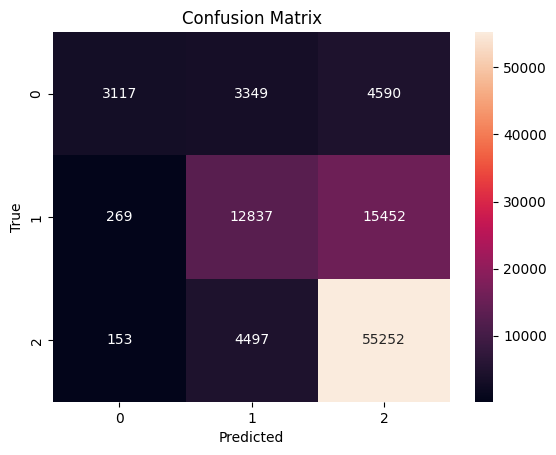

In [10]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(reviews_train, sentiments_train)
sentiments_pred = clf.predict(reviews_test)

# Stampa il rapporto di classificazione
print(classification_report(sentiments_test, sentiments_pred))
# Salvare il modello addestrato
dump(clf, 'svm.joblib')
# Caricare il modello
svm_loaded = load('svm.joblib')print(classification_report(sentiments_test, sentiments_pred)),
cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
clf = LinearSVC(dual=True, max_iter=10000)

clf.fit(reviews_train, sentiments_train)
sentiments_pred = clf.predict(reviews_test)

print(classification_report(sentiments_test, sentiments_pred))
cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

              precision    recall  f1-score   support

           0       0.59      0.55      0.57     11056
           1       0.60      0.39      0.47     28558
           2       0.75      0.89      0.81     59902

    accuracy                           0.71     99516
   macro avg       0.65      0.61      0.62     99516
weighted avg       0.69      0.71      0.69     99516



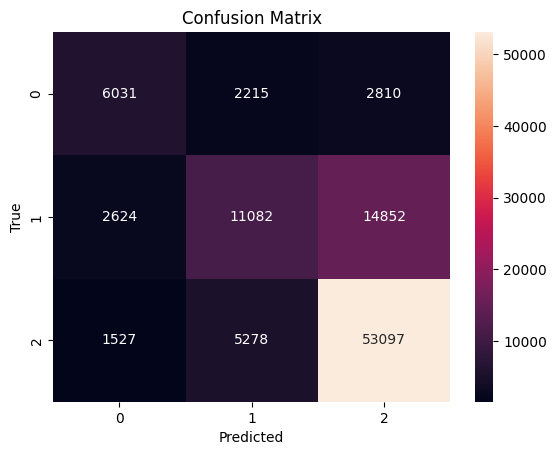

In [11]:
classifier = MultinomialNB()
classifier.fit(reviews_train, sentiments_train)
sentiments_pred = classifier.predict(reviews_test)
print(classification_report(sentiments_test, sentiments_pred))

# Salvare il modello addestrato
dump(clf, 'bayes.joblib')
# Caricare il modello
nb_loaded = load('bayes.joblib')

cm = confusion_matrix(sentiments_test, sentiments_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [1]:
#WordCloud per sentimenti positivi
positive_reviews = df[df['sentiment'] == 2]['reviewText'].str.cat(sep=' ')
wordcloud = WordCloud(background_color='white', max_words=200).generate(positive_reviews)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud per sentimenti negativi
negative_reviews = df[df['sentiment'] == 0]['reviewText'].str.cat(sep=' ')
wordcloud_negative = WordCloud(background_color='white', max_words=200, contour_color='red').generate(negative_reviews)
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud')
plt.show()

NameError: name 'df' is not defined

In [ ]:
# Calcolo delle metriche per il confronto dei modelli
from sklearn.metrics import precision_recall_fscore_support as score

# Calcola metriche per Random Forest
precision_rf, recall_rf, fscore_rf, _ = score(sentiments_test, rf_loaded.predict(reviews_test), average='weighted')

# Calcola metriche per SVM
precision_svm, recall_svm, fscore_svm, _ = score(sentiments_test, svm_loaded.predict(reviews_test), average='weighted')

# Calcola metriche per Naive Bayes
precision_nb, recall_nb, fscore_nb, _ = score(sentiments_test, nb_loaded.predict(reviews_test), average='weighted')

# Creazione del grafico a barre per confrontare i modelli
import numpy as np

models = ['Random Forest', 'SVM', 'Naive Bayes']
precision_scores = [precision_rf, precision_svm, precision_nb]
recall_scores = [recall_rf, recall_svm, recall_nb]
fscore_scores = [fscore_rf, fscore_svm, fscore_nb]

x = np.arange(len(models))  
width = 0.25  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_scores, width, label='Precision')
rects2 = ax.bar(x, recall_scores, width, label='Recall')
rects3 = ax.bar(x + width, fscore_scores, width, label='F1-Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()